# Linear Model Selection

## Question

In this exercise, we will predict the number of applications received using the other variables in the `College` data set.

1. Split the data set into a training and a test set.
2. Fit a linear model using least squares on the training set, and report the test error obtained.
3. Fit a ridge regression model on the training set, with $\alpha$ chosen by cross-validation. Report the test error obtained.
4. Fit a lasso model on the training set, with $\alpha$ chosen by cross-validation. Report the test error obtained, along with the number of non-zero coefficient estimates.
5. Fit a PCR model on the training set, with M chosen by cross-validation. Report the test error obtained, along with the value of M selected by cross-validation.
6. Fit a PLS model on the training set, with M chosen by cross-validation. Report the test error obtained, along with the value of M selected by cross-validation.
7. Comment on the results obtained. How accurately can we predict the number of college applications received? Is there much difference among the test errors resulting from these five approaches?

In [20]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import itertools

from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV

from sklearn.preprocessing import scale
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score

import matplotlib.pyplot as plt
% matplotlib inline
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import log_loss

from pylab import rcParams
rcParams['figure.figsize']= 10,5

In [7]:
colleges= pd.read_csv("College (1).csv", index_col =0)

In [8]:
print(colleges.shape)
print(colleges.info())
colleges['Private01'] = np.where(colleges['Private'] == "Yes", 1, 0)
colleges= colleges.drop('Private', 1)
colleges.head()

(777, 18)
<class 'pandas.core.frame.DataFrame'>
Index: 777 entries, Abilene Christian University to York College of Pennsylvania
Data columns (total 18 columns):
Private        777 non-null object
Apps           777 non-null int64
Accept         777 non-null int64
Enroll         777 non-null int64
Top10perc      777 non-null int64
Top25perc      777 non-null int64
F.Undergrad    777 non-null int64
P.Undergrad    777 non-null int64
Outstate       777 non-null int64
Room.Board     777 non-null int64
Books          777 non-null int64
Personal       777 non-null int64
PhD            777 non-null int64
Terminal       777 non-null int64
S.F.Ratio      777 non-null float64
perc.alumni    777 non-null int64
Expend         777 non-null int64
Grad.Rate      777 non-null int64
dtypes: float64(1), int64(16), object(1)
memory usage: 115.3+ KB
None


,Apps,Accept,Enroll,Top10perc,Top25perc,F.Undergrad,P.Undergrad,Outstate,Room.Board,Books,Personal,PhD,Terminal,S.F.Ratio,perc.alumni,Expend,Grad.Rate,Private01
Abilene Christian University,1660,1232,721,23,52,2885,537,7440,3300,450,2200,70,78,18.1,12,7041,60,1
Adelphi University,2186,1924,512,16,29,2683,1227,12280,6450,750,1500,29,30,12.2,16,10527,56,1
Adrian College,1428,1097,336,22,50,1036,99,11250,3750,400,1165,53,66,12.9,30,8735,54,1
Agnes Scott College,417,349,137,60,89,510,63,12960,5450,450,875,92,97,7.7,37,19016,59,1
Alaska Pacific University,193,146,55,16,44,249,869,7560,4120,800,1500,76,72,11.9,2,10922,15,1


In [9]:
colleges.columns

Index(['Apps', 'Accept', 'Enroll', 'Top10perc', 'Top25perc', 'F.Undergrad',
       'P.Undergrad', 'Outstate', 'Room.Board', 'Books', 'Personal', 'PhD',
       'Terminal', 'S.F.Ratio', 'perc.alumni', 'Expend', 'Grad.Rate',
       'Private01'],
      dtype='object')

In [10]:
colleges.describe()

,Apps,Accept,Enroll,Top10perc,Top25perc,F.Undergrad,P.Undergrad,Outstate,Room.Board,Books,Personal,PhD,Terminal,S.F.Ratio,perc.alumni,Expend,Grad.Rate,Private01
count,777.000000,777.000000,777.000000,777.000000,777.000000,777.000000,777.000000,777.000000,777.000000,777.000000,777.000000,777.000000,777.000000,777.000000,777.000000,777.000000,777.00000,777.000000
mean,3001.638353,2018.804376,779.972973,27.558559,55.796654,3699.907336,855.298584,10440.669241,4357.526384,549.380952,1340.642214,72.660232,79.702703,14.089704,22.743887,9660.171171,65.46332,0.727156
std,3870.201484,2451.113971,929.176190,17.640364,19.804778,4850.420531,1522.431887,4023.016484,1096.696416,165.105360,677.071454,16.328155,14.722359,3.958349,12.391801,5221.768440,17.17771,0.445708
min,81.000000,72.000000,35.000000,1.000000,9.000000,139.000000,1.000000,2340.000000,1780.000000,96.000000,250.000000,8.000000,24.000000,2.500000,0.000000,3186.000000,10.00000,0.000000
25%,776.000000,604.000000,242.000000,15.000000,41.000000,992.000000,95.000000,7320.000000,3597.000000,470.000000,850.000000,62.000000,71.000000,11.500000,13.000000,6751.000000,53.00000,0.000000
50%,1558.000000,1110.000000,434.000000,23.000000,54.000000,1707.000000,353.000000,9990.000000,4200.000000,500.000000,1200.000000,75.000000,82.000000,13.600000,21.000000,8377.000000,65.00000,1.000000
75%,3624.000000,2424.000000,902.000000,35.000000,69.000000,4005.000000,967.000000,12925.000000,5050.000000,600.000000,1700.000000,85.000000,92.000000,16.500000,31.000000,10830.000000,78.00000,1.000000
max,48094.000000,26330.000000,6392.000000,96.000000,100.000000,31643.000000,21836.000000,21700.000000,8124.000000,2340.000000,6800.000000,103.000000,100.000000,39.800000,64.000000,56233.000000,118.00000,1.000000


In [106]:
train, test = train_test_split(colleges, test_size= .5, random_state=0)

In [111]:
train_x= train.drop('Apps', 1)
test_x= test.drop('Apps', 1)
train_y= train['Apps']
test_y= test['Apps']

In [112]:
len(test_y)

389

In [13]:
colleges.corr()

,Apps,Accept,Enroll,Top10perc,Top25perc,F.Undergrad,P.Undergrad,Outstate,Room.Board,Books,Personal,PhD,Terminal,S.F.Ratio,perc.alumni,Expend,Grad.Rate,Private01
Apps,1.000000,0.943451,0.846822,0.338834,0.351640,0.814491,0.398264,0.050159,0.164939,0.132559,0.178731,0.390697,0.369491,0.095633,-0.090226,0.259592,0.146755,-0.432095
Accept,0.943451,1.000000,0.911637,0.192447,0.247476,0.874223,0.441271,-0.025755,0.090899,0.113525,0.200989,0.355758,0.337583,0.176229,-0.159990,0.124717,0.067313,-0.475252
Enroll,0.846822,0.911637,1.000000,0.181294,0.226745,0.964640,0.513069,-0.155477,-0.040232,0.112711,0.280929,0.331469,0.308274,0.237271,-0.180794,0.064169,-0.022341,-0.567908
Top10perc,0.338834,0.192447,0.181294,1.000000,0.891995,0.141289,-0.105356,0.562331,0.371480,0.118858,-0.093316,0.531828,0.491135,-0.384875,0.455485,0.660913,0.494989,0.164132
Top25perc,0.351640,0.247476,0.226745,0.891995,1.000000,0.199445,-0.053577,0.489394,0.331490,0.115527,-0.080810,0.545862,0.524749,-0.294629,0.417864,0.527447,0.477281,0.095752
F.Undergrad,0.814491,0.874223,0.964640,0.141289,0.199445,1.000000,0.570512,-0.215742,-0.068890,0.115550,0.317200,0.318337,0.300019,0.279703,-0.229462,0.018652,-0.078773,-0.615561
P.Undergrad,0.398264,0.441271,0.513069,-0.105356,-0.053577,0.570512,1.000000,-0.253512,-0.061326,0.081200,0.319882,0.149114,0.141904,0.232531,-0.280792,-0.083568,-0.257001,-0.452088
Outstate,0.050159,-0.025755,-0.155477,0.562331,0.489394,-0.215742,-0.253512,1.000000,0.654256,0.038855,-0.299087,0.382982,0.407983,-0.554821,0.566262,0.672779,0.571290,0.552650
Room.Board,0.164939,0.090899,-0.040232,0.371480,0.331490,-0.068890,-0.061326,0.654256,1.000000,0.127963,-0.199428,0.329202,0.374540,-0.362628,0.272363,0.501739,0.424942,0.340532
Books,0.132559,0.113525,0.112711,0.118858,0.115527,0.115550,0.081200,0.038855,0.127963,1.000000,0.179295,0.026906,0.099955,-0.031929,-0.040208,0.112409,0.001061,-0.018549


In [14]:
# Removed Factors >>> +S.F.Ratio+perc.alumni+Grad.Rate+Private01+F.Undergrad+P.Undergrad+Outstate
lm = smf.ols("Apps ~ Accept+Enroll+Top10perc+Top25perc+Expend+Books+Personal+PhD+Terminal", data = train).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   Apps   R-squared:                       0.920
Model:                            OLS   Adj. R-squared:                  0.918
Method:                 Least Squares   F-statistic:                     485.2
Date:                Sun, 26 Mar 2017   Prob (F-statistic):          1.36e-201
Time:                        18:54:33   Log-Likelihood:                -3267.3
No. Observations:                 388   AIC:                             6555.
Df Residuals:                     378   BIC:                             6594.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept   -289.5551    381.218     -0.760      0.448     -1039.129   460.019
Accept         1.3236      0.064     20.626      0.000         1.197     1.450
Enroll         0.2305      0.159      1.446      0.149        -0.083     0.544
Top10perc     52.6062      8.179      6.432      0.000        36.524    68.688
Top25perc    -20.0757      6.733     -2.982      0.003       -33.314    -6.837
Expend         0.0513      0.017      3.052      0.002         0.018     0.084
Books          0.0767      0.327      0.235      0.815        -0.566     0.719
Personal      -0.0009      0.085     -0.011      0.991        -0.168     0.167
PhD           -4.9089      7.812     -0.628      0.530       -20.270    10.452
Terminal      -0.4844      8.427     -0.057      0.954       -17.054    16.085
==============================================================================
Omnibus:                      214.524   Durbin-Watson:                   2.014
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2080.575
Skew:                           2.155   Prob(JB):                         0.00
Kurtosis:                      13.493   Cond. No.                     7.59e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.59e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [132]:
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA


lr = LinearRegression()
lr.fit(train_x, train_y)

mean_squared_error(test_y, lr.predict(test_x))

1260390.8426038101

In [158]:
type(lr)

sklearn.linear_model.base.LinearRegression

In [26]:
import numpy as np
grid = 10**np.linspace(-2,4,100)

rr_college = RidgeCV(alphas=grid)
rr_college = rr_college.fit(train_x, train_y)

mean_squared_error(test_y, rr_college.predict(test_x))

1257064.5140894572

In [27]:
lr_college = LassoCV(alphas=grid)
lr_college = lr_college.fit(train_x, train_y)

mean_squared_error(test_y, lr_college.predict(test_x))

1246052.2511365062

In [113]:
from sklearn.model_selection import cross_val_score
pca= PCA()
pc_train_x= pca.fit_transform(scale(train_x))
pc_test_x= pca.fit_transform(scale(test_x))

MSE= []
pcr_college = LinearRegression()
MSE.append(np.mean(-1 *cross_val_score(pcr_college,
                                      np.ones((len(pc_train_x), 1)),
                                       train_y,
                                       cv=10,
                                       scoring= "neg_mean_squared_error")))
for i in range(1, len(train_x.columns)):
    MSE_temp = -1 *cross_val_score(pcr_college,
                                      pc_train_x[:,:i],
                                       train_y,
                                       cv=10,
                                       scoring= "neg_mean_squared_error")
    MSE_temp= np.mean(MSE_temp)
    MSE.append(MSE_temp)    

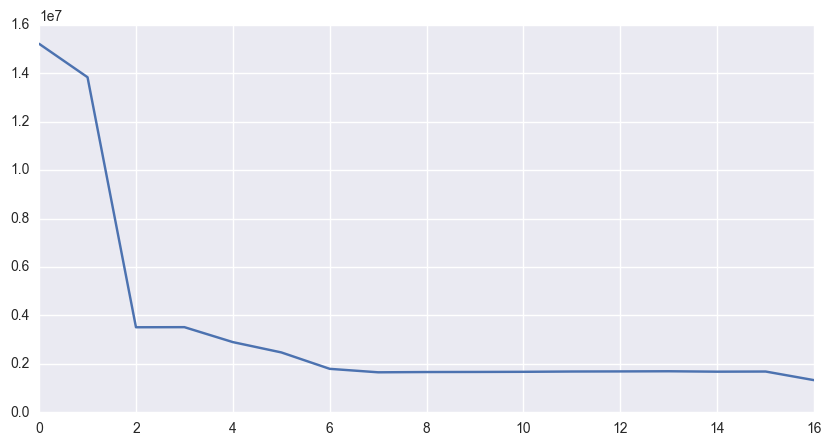

In [34]:
plt.plot(MSE)
plt.show()

In [101]:
from sklearn.cross_decomposition import PLSRegression
pls_college = PLSRegression(n_components =10)
pls_college.fit(scale(train_x), train_y) 
mean_squared_error(test_y, lr_college.predict(test_x))

1246052.2511365062

In [114]:
# Not certain why this is blowing up 
pcr_college.fit(pc_train_x[:,0:9], train_y)
mean_squared_error(test_y, pcr_college.predict(pc_test_x[:,0:9]))
#len(pc_test_x)

7393519.7843770441

In [157]:
type(pc_test_x)

numpy.ndarray

In [133]:
print(test_x.shape)
print(test_y.shape)

(389, 17)
(389,)


In [135]:
(lr.score(test_x, test_y),
rr_college.score(test_x, test_y),
lr_college.score(test_x, test_y),
pcr_college.score(pc_test_x[:,0:9], test_y),
pls_college.score(scale(test_x), test_y))

(0.9143027241482764,
 0.91452888993957882,
 0.91527764255196786,
 0.4972952174358955,
 0.90880120301051459)

## Question

We have seen that as a number of features used in a model increases, the training error will necessarily decrease, but the test error may not. We will now explore this in a simulated data set.

1. Generate a data set with $p = 20$ features, $n = 1000$ observations, and an associated quantitative response vector generated according to the model $$Y = X\beta + \epsilon$$ where β has some elements that are exactly equal to zero.
2. Split your data set into a training set containing 100 observations and a test set containing 900 observations.
3. Perform best subset selection on the training set, and plot the training set MSE associated with the best model of each size.
4. Plot the test MSE associated with the best model of each size.
5. For which model size does the test set MSE take on its minimum value? Comment on your results. It it takes on its minimum value for a model containing only an intercept or a model containing all the features, then play around with the way that you are generating the data in (1) until you come up with a scenario in which the test MSE is minimized for an intermediate model size.
6. How does the model at which the test set MSE is minimized compare to the true model used to generate the data ? Comment on the coefficient values.
7. Create a plot displaying $$\sqrt{\sum_{j=1}^p(\beta_j - \hat{\beta}_j^r)^2}$$ for a range of values of r where $\hat{\beta}_j^r$ is the jth coefficient estimate for the best model containing r coefficients. Comment on what you observe. How does this compare to the test MSE plot from (4)?

In [58]:
import random
np.random.seed(3)
n= np.random.randn(1000, 20)
b= np.random.randn(20)

b[3] = 0
b[5] = 0
b[7] = 0
b[9] = 0
b[11] = 0

eps = np.random.randn(1000)

y = np.matmul(x,b) +eps

In [142]:
train, test = train_test_split(np.column_stack((x,y)), test_size=900, random_state= 0)

train_x = train[:,:19]
test_x = test[:,:19]
train_y = train[:,20]
test_y = test[:,20]

In [172]:
# package, module import object, function
from sklearn.feature_selection import SelectKBest, f_regression 
lm=  LinearRegression()
MSE = []

for i in range(1,20):
    temp = SelectKBest(f_regression, k=i)
    temp = temp.fit_transform(train_x, train_y)
    temp_ln = lm.fit(temp, train_y)
    MSE.append(mean_squared_error(train_y, temp_ln.predict(temp)))

lm_full= lm.fit(train_x, train_y)    
MSE.append(mean_squared_error(train_y, temp_ln.predict(temp)))


In [173]:
#temp
print(temp)
#type(temp))

[[-0.67524937 -0.61858503 -1.07314986 ...,  1.04637732 -0.24785199
   0.96709746]
 [ 0.68322351  0.3252358  -0.04154044 ...,  2.03457678  1.51062896
  -0.27887595]
 [ 0.40440389 -0.72313522 -2.41126132 ..., -0.32817967 -1.97286997
  -1.29249961]
 ..., 
 [-0.89060204  0.24882628 -2.10149198 ...,  0.71415894 -1.13646275
   1.63605149]
 [ 0.73950591 -1.59695448 -0.24861658 ..., -2.36677935 -1.93858506
   0.9225504 ]
 [ 0.5772154  -1.42406158  0.30741513 ...,  0.12605033 -0.13269715
  -0.76885304]]


In [159]:
print(MSE)

[6.5988563645308895, 4.7034899011276279, 3.3981267608850887, 2.7078746954356934, 2.2089390014137602, 2.1114721941679035, 1.8699539899957245, 1.8699299506899913, 1.7839166883601676, 1.781424970314639, 1.7754774299878133, 1.7424045588478101, 1.7389681102850836, 1.687818017099491, 1.1527732520317053, 1.1525558699111487, 1.1409858894040779, 0.88367369111440075, 0.88359063538599036, 0.88359063538599036]


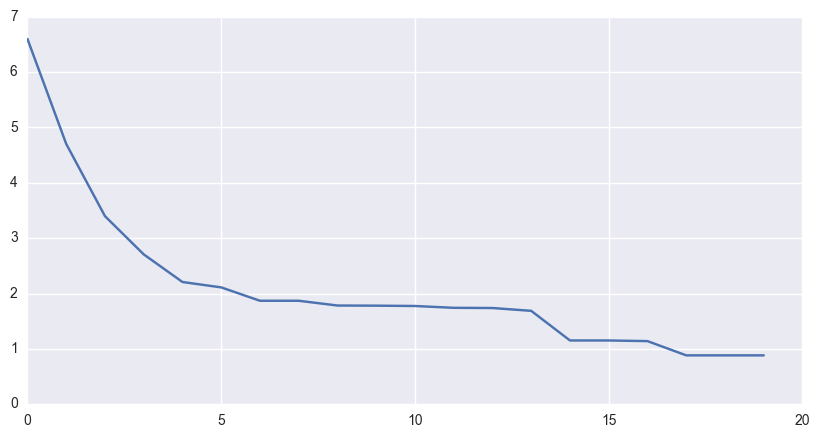

In [66]:
plt.plot(MSE)
plt.show()

In [174]:
lm = LinearRegression()

features= []
coef = []
MSE = []

for i in range(1,20):
        temp = SelectKBest(f_regression, k=i)
        temp = temp.fit(train_x, train_y)
        temp_lm = lm.fit(train_x[:, temp.get_support()], train_y)
        features.append(temp.get_support(indices=True))
        coef.append(temp_lm.coef_)
        MSE.append(mean_squared_error(test_y, temp_lm.predict(test_x[:, temp.get_support()])))

lm_full= lm.fit(train_x, train_y)    
MSE.append(mean_squared_error(test_y, temp_ln.predict(test_x)))
coef.append(lm_full.coef_)
features.append(np.arange(0,21))        
    

In [180]:
temp.get_support()

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,  True], dtype=bool)

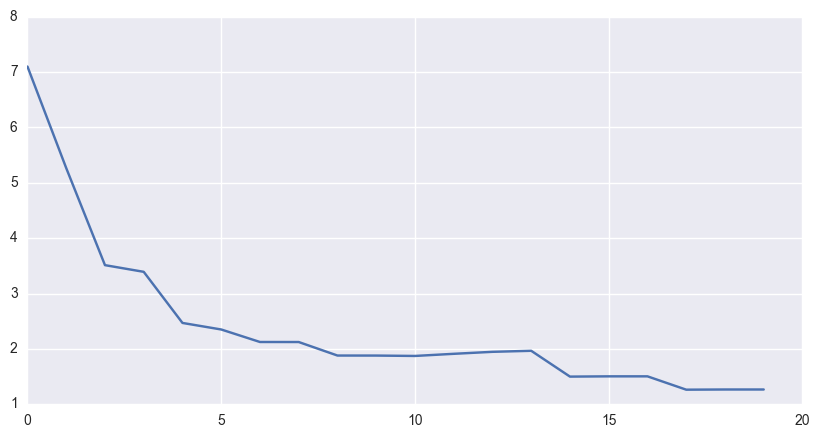

In [76]:
plt.plot(MSE)
plt.show()

## Question

We will now try to predict per capita crime rate in the `Boston` data set.

1. Try out some of the regression methods explored in this chapter, such as best subset selection, the lasso, ridge regression and PCR. Present and discuss results for the approaches that you consider.
2. Propose a model (or set of models) that seem to perform well on this data set, and justify your answer. Make sure that you are evaluating model performance using validation set error, cross-validation, or some other reasonable alternative, as opposed to using training error.
3. Does your chosen model involve all of the features in the data set ? Why or why not ?

In [81]:
boston = pd.read_csv("Boston (3).csv", index_col= 0)
train, test = train_test_split(boston, test_size=.2, random_state= 0)


train_x = train.drop('crim', axis=1)
test_x = test.drop('crim', axis=1)
train_y = train['crim']
test_y = test['crim']

In [86]:
lm = LinearRegression()

MSE= []
for i in range(1, len(train_x.columns)):
        temp = SelectKBest(f_regression, k=i)
        temp = temp.fit(train_x, train_y)
        temp_lm = lm.fit(train_x.iloc[:, temp.get_support()], train_y)
        MSE.append(mean_squared_error(test_y, temp_lm.predict(test_x.iloc[:, temp.get_support()])))

lm_full= lm.fit(train_x, train_y)    
MSE.append(mean_squared_error(test_y, temp_lm.predict(test_x)))    

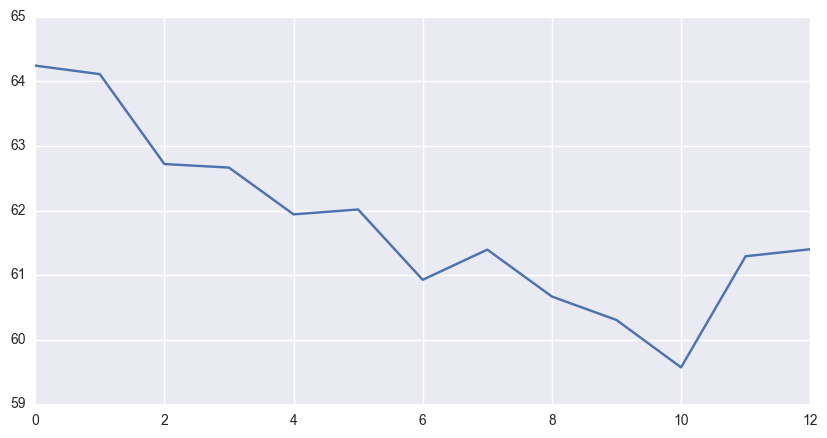

In [87]:
plt.plot(MSE)
plt.show()

In [89]:
MSE.index(min(MSE))

10

In [90]:
min(MSE)

59.571530672273674

In [91]:
lr = LassoCV(alphas=grid)
lr.fit(train_x, train_y)

print(mean_squared_error(test_y, lr.predict(test_x)))

rr = LassoCV(alphas=grid)
rr.fit(train_x, train_y)

print(mean_squared_error(test_y, rr.predict(test_x)))

61.2757940854
61.2757940854


In [92]:
pca= PCA()
pc_train_x= pca.fit_transform(scale(train_x))
pc_test_x= pca.fit_transform(scale(train_x))

MSE= []
pcr = LinearRegression()
MSE.append(np.mean(-1 *cross_val_score(pcr,
                                      np.ones((len(pc_train_x), 1)),
                                       train_y,
                                       cv=10,
                                       scoring= "neg_mean_squared_error")))
for i in range(1, len(train_x.columns)):
    MSE_temp = -1 *cross_val_score(pcr,
                                      pc_train_x[:,:i],
                                       train_y,
                                       cv=10,
                                       scoring= "neg_mean_squared_error")
    MSE_temp= np.mean(MSE_temp)
    MSE.append(MSE_temp)    

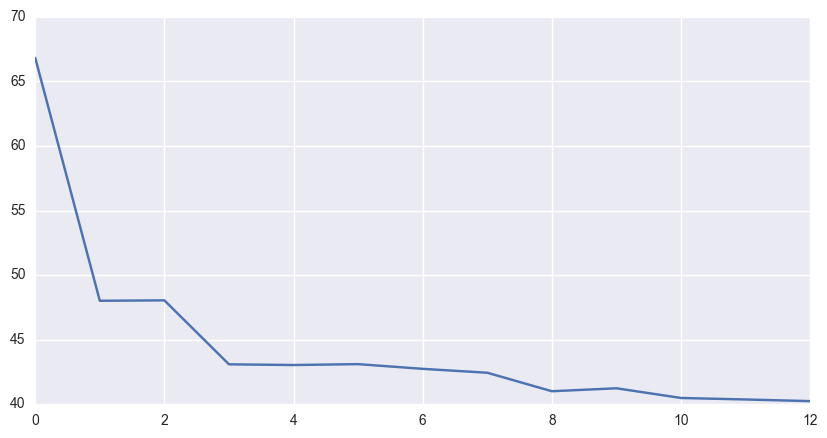

In [93]:
plt.plot(MSE)

In [94]:
MSE.index(min(MSE))

12

In [95]:
min(MSE)

40.243260875379306